<a href="https://colab.research.google.com/github/vinodkmani/pandas_exercises/blob/master/VedioMemorability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/',force_remount=True)
os.chdir('/content/drive/My Drive/MachineLearning/CA684_Assignment/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
#Fetching inception features 
def fetch_inceptionFeatures(filename):
    with open(filename) as f:
        for line in f:
            pairs=line.split()
            incept_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
    
    incept = np.zeros(6075)
    for idx in incept_temp.keys():
        incept[idx-1] = incept_temp[idx]            
    return incept

In [0]:
#Fetching captions
def read_captions(fname):
    """Fetching the captions to dataframe"""
    ved = []
    capt = []
    df = pd.DataFrame();
    with open(fname) as f:
        for line in f:
            pairs = line.split()
            ved.append(pairs[0])
            capt.append(pairs[1])
        df['video']=ved
        df['caption']=capt
    return df

In [4]:
!pip install pyprind

In [5]:
import pandas as pd
import numpy as np
import os
import keras
import pyprind
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [0]:
#Fetching inception features
df = pd.DataFrame(columns = ['video', 'arrayInfo'])
dir_inception = '/content/drive/My Drive/MachineLearning/CA684_Assignment/Dev-set/InceptionV3'

for fname in os.listdir(dir_inception):
    if fname.endswith(".txt"):
        path = os.path.join(dir_inception, fname)
        array = fetch_inceptionFeatures(path)
        if "-56" in fname:
          fname.replace('-56','')
          fName= fname.replace(".txt",".webm")
          df = df.append({'video': fName, 'arrayInfo': array}, ignore_index=True)
    else:
        break

In [10]:
df.count()

video        6000
arrayInfo    6000
dtype: int64

In [0]:
count=0
for item in df['video']:
  df['video'][count]=item.replace('-56.webm','.webm')
  count = count + 1

In [0]:
label_path = '/content/drive/My Drive/MachineLearning/CA684_Assignment/Dev-set/Ground-truth/'
labels=pd.read_csv(label_path+'ground-truth.csv')

In [19]:
df_inception = df.merge(labels,on=["video"],how="inner")
df_inception.columns
df_inception.head()

,video,arrayInfo,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video7364.webm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.891,33,0.900,10
1,video737.webm,"[2.826083e-36, 0.0, 0.0, 0.0, 1.199688e-28, 0....",0.914,44,1.000,11
2,video7373.webm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.954,31,0.917,12
3,video7370.webm,"[2.318133e-24, 3.561454e-29, 2.048143e-24, 4.1...",0.951,33,0.938,16
4,video7372.webm,"[1.123148e-33, 0.0, 0.0, 0.0, 5.879868e-27, 0....",0.960,47,1.000,15


In [20]:
merged_arr = np.empty((0, 6075))
merged_arr

array([], shape=(0, 6075), dtype=float64)

In [0]:
for line in df_inception['arrayInfo']:
    merged_arr = np.append(merged_arr, np.array([line]), axis = 0)

In [0]:
arrayInfo = df_inception['arrayInfo'].values

In [0]:
X_inception = merged_arr

In [24]:
print(type(X_inception))
X_inception

<class 'numpy.ndarray'>


array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [2.826083e-36, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]])

In [0]:
Y=df_inception[['short-term_memorability','long-term_memorability']].values  #target
X=X_inception #input

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42) # random state for reproducability

print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('Y_train', Y_train.shape)
print('Y_test', Y_test.shape)

X_train (4800, 6075)
X_test (1200, 6075)
Y_train (4800, 2)
Y_test (1200, 2)


In [27]:
col_num = X_train.shape[1]
col_num

6075

In [0]:
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(col_num,)))
#The second layer
model.add(Dense(100, activation='relu'))
#The output layer
model.add(Dense(2))

In [0]:
# Compiling and defining early_stopping_monitor 
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
early_stopping_monitor = EarlyStopping(patience=2)	

In [0]:
#To calculate Spearmann"s correlation coefficient	
def Calculate_SpearmanScore(Y_prediction,Y_true):
    '''Spearmann"s correlation coefficient'''
    Y_prediction = np.squeeze(Y_prediction)
    Y_true = np.squeeze(Y_true)
    if Y_prediction.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_prediction.shape) == 1:
            Result = pd.DataFrame({'Y_true':Y_true,'Y_prediction':Y_prediction})
            score = Result[['Y_true','Y_prediction']].corr(method='spearman',min_periods=1)
            print('Spearman\'s correlation coefficient : %.3f' % score.iloc[1][0])
        else:
            for ii in range(Y_prediction.shape[1]):
                Calculate_SpearmanScore(Y_prediction[:,ii],Y_true[:,ii])

Train on 3360 samples, validate on 1440 samples
Epoch 1/30
3360/3360 [==============================] - 2s 626us/step - loss: 0.1345 - accuracy: 0.6268 - val_loss: 0.0141 - val_accuracy: 0.6986
Epoch 2/30
3360/3360 [==============================] - 2s 510us/step - loss: 0.0137 - accuracy: 0.7039 - val_loss: 0.0138 - val_accuracy: 0.6965
Epoch 3/30
3360/3360 [==============================] - 2s 517us/step - loss: 0.0136 - accuracy: 0.7051 - val_loss: 0.0141 - val_accuracy: 0.6951
Epoch 4/30
3360/3360 [==============================] - 2s 506us/step - loss: 0.0136 - accuracy: 0.7051 - val_loss: 0.0139 - val_accuracy: 0.6958


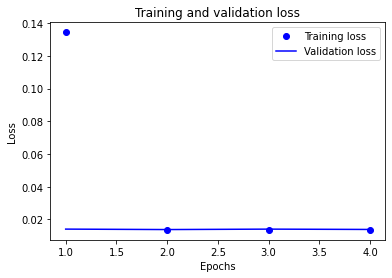

In [31]:
# Fit the model
historyMod=model.fit(X_train, Y_train, validation_split=0.3, epochs=30, callbacks= [early_stopping_monitor])
loss = historyMod.history['loss']
val_loss = historyMod.history['val_loss']
epochs = range(1,len(loss)+1)
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
model_predictions = model.predict(X_test)
print(model_predictions)
Calculate_SpearmanScore(model_predictions, Y_test)

[[0.87100303 0.7734306 ]
 [0.8391351  0.77812517]
 [0.8673724  0.7866619 ]
 ...
 [0.86533433 0.79132134]
 [0.8586352  0.78081083]
 [0.8366358  0.753265  ]]
Spearman's correlation coefficient : 0.131
Spearman's correlation coefficient : 0.041
